In this example we will use ABMax to create a simple cellular automata based model for traffic simulation. Where, cars move in one direction across a 3 lane road. 
Cars are spawned randomly at one end, then they move forward if the cell in front of them is empty, else they try to change lanes. If they cannot change lanes they stay in place. At the exit of the road they are removed from the simulation if the signal for that lane is green.

The simulation consists of :
1) Car agents: representing the cars on the road.
2) Cell agents: representing the cells on the road in spirit of cellular automata.

In [ ]:
#import sys
#sys.path.append('../../ABMax/')


import jax.numpy as jnp
import jax.random as random
import jax
import flax

from flax import struct

from abmax.structs import *
from abmax.functions import *
from abmax.contexts.traffic.algorithms import *

Preliminaries:
1. structs.py: Contains the data structures from ABMax needed for the simulation.
2. functions.py: Contains the functions needed to run the simulation.
3. JAX version: 0.4.13
4. flax version: 0.7.4

In [2]:
print("JAX version:", jax.__version__)
print("Flax version:", flax.__version__)

JAX version: 0.4.13
Flax version: 0.7.4


Global parameters to set up the simulation:

In [3]:
X_MAX = jnp.array([3]) # number of lanes in the road, X direction
Y_MAX = jnp.array([7]) # length of the road, Y direction
NUM_CARS = 25 # number of cars in the simulation
Dt = 1.0  # time step

CAR_AGENT_TYPE = 0 # agent type for cars
CELL_AGENT_TYPE = 1 # agent type for cells
KEY = random.PRNGKey(1) # random key for JAX
NUM_ROADS = 10 # number of roads in the simulation
TIME_STEPS = 100 # total number of time steps for the simulation

# A dictionary of parameters to create the road
ROAD_CREATE_PARAMS = {
    'X_max': X_MAX,
    'Y_max': Y_MAX,
    'cell_agent_type': CELL_AGENT_TYPE,
    'car_agent_type': CAR_AGENT_TYPE,
    'num_cars': NUM_CARS,
}

Step 1: Define the car agent by inheriting from the Agent class in structs.py. A Car agent is defined by:
1. State:
- current_cell_id: The id of the cell the car is currently in.
- requested_cell_id: The id of the cell the car wants to move to.
- wait_time: The time the car has been waiting in the current cell.

2. Parameters:
- destination_cell_id: The id of the cell the car wants to reach. (Note: Not used in this simple simulation but can be used to extend the simulation to multiple roads and intersections)

The car agent is responsible for:
- Randomly deciding which cell to move to next (requested_cell_id) based on the state of the cells around it.
    - The car in lane 0 (X=0) can either move forward in the same lane or change to lane 1 (X=1).
    - The car in lane 1 (X=1) can either move forward in the same lane, change to lane 0 (X=0) or change to lane 2 (X=2).
    - The car in lane 2 (X=2) can either move forward in the same lane or change to lane 1 (X=1).
- Updating its current_cell_id based on inputs from the cell agents.

Thus, the Car(Agent) implements:
1. create_agents: to create an inactive car agent.
2. add_agent_sci(): to update the car agent with details of a new car. This is unique for each car and thus uses sort-count-iterate kernel for execution.
3. remove_agent(): to remove the car agent when it reaches its destination. This is not car specific and thus uses set-mask kernel for execution.
4. step_agent(): to update the state of the car agent.

In [4]:
@struct.dataclass
class Car(Agent):
    @staticmethod
    def create_agent(type, param, id, active_state, key) -> Agent:
        '''
        Create an empty car agent with the given parameters
        args:
            type: type of the agent
            param: parameters to create the agent
            id: id of the agent
            active_state: whether the agent is active or not
            key: random key for agent creation
        returns:
            an empty car agent with the given parameters
        '''
        
        current_cell_id = jnp.array([-1]) # current cell id of the car, -1 means the car is not on the road
        request_cell_id = jnp.array([-1]) # cell id of the cell the car wants to move to, -1 means the car is not on the road
        destination_cell_id = jnp.array([-1]) # destination cell id of the car, -1 means the car is not on the road
        wait_time = jnp.array([-1.0]) # time the car has been waiting to move, -1 means the car is not on the road

        state_content = {'current_cell_id': current_cell_id, 'request_cell_id': request_cell_id, 'wait_time': wait_time}
        agent_state = State(content=state_content)

        param_content = {'destination_cell_id': destination_cell_id}
        agent_params = Params(content=param_content)

        return Car(id=id, active_state=active_state, age = 0.0, agent_type=type, params=agent_params, state=agent_state, policy=None, key=key)
    

    @staticmethod
    def add_agent_sci(agents, idx, add_params) -> Agent:
        '''
        Add a car agent to the simulation with the given parameters
        args:
            agents: list of all car agents
            idx: index of the car agent to be added
            add_params: parameters to add the agent
        returns:
            the car agent with the given parameters
        '''
        set_indx = add_params.content['set_indx'] # index of the car agent to be added in the set of car agents
        current_cell_ids = add_params.content['current_cell_ids'] # current cell ids of the car agents to be added

        agent_to_add = jax.tree_util.tree_map(lambda x: x[set_indx[idx]], agents) # get the car agent to be added

        new_current_cell_id = current_cell_ids[idx] # set the current cell id of the car agent to be added
        new_wait_time = jnp.array([0.0]) # set the wait time of the car agent to be added to 0
        new_request_cell_id = jnp.array([-1]) # set the request cell id of the car agent to be added to -1
        
        new_state_content = {'current_cell_id': new_current_cell_id, 
                             'request_cell_id': new_request_cell_id,
                             'wait_time': new_wait_time} 
        new_state = State(content=new_state_content)

        new_destination_cell_id = jnp.array([-1])  # Assuming destination cell id is not provided in this case and set to -1
        new_param_content = {'destination_cell_id': new_destination_cell_id}
        new_params = Params(content=new_param_content)

        return agent_to_add.replace(state=new_state, params=new_params, age=0.0, active_state = 1)
    
    @staticmethod
    def remove_agent(agent, remove_params) -> Agent:
        '''
        Remove a car agent from the simulation
        args:
            agent: car agent to be removed
            remove_params: parameters to remove the agent
        returns:
            the car agent with default parameters indicating it is inactive
        '''
        new_current_cell_id = jnp.array([-1])
        new_request_cell_id = jnp.array([-1])
        new_wait_time = jnp.array([-1.0])
        new_state_content = {'current_cell_id': new_current_cell_id, 
                             'request_cell_id': new_request_cell_id, 
                             'wait_time': new_wait_time}
        new_state = State(content=new_state_content)
        
        new_destination_cell_id = jnp.array([-1])
        new_param_content = {'destination_cell_id': new_destination_cell_id}
        
        new_params = Params(content=new_param_content)
        return agent.replace(state=new_state, params=new_params, age=0.0, active_state = 0)

    
    @staticmethod
    def step_agent(agent: Agent, input: Signal, step_params: Params) -> Agent:
        '''
        Step the car agent in the simulation
        args:
            agent: car agent to be stepped
            input: input signal for the agent
            step_params: parameters for the step function
        returns:
            the updated car agent after stepping
        '''
        
        def step_inactive_agent(): # if the car is inactive, do nothing
            return agent
        
        def step_active_agent():
            request_cell_id = agent.state.content['request_cell_id']
            current_cell_id = agent.state.content['current_cell_id']
            wait_time = agent.state.content['wait_time']

            dt = step_params.content['dt']

            car_chosen = input.content['car_chosen']
            X_max = step_params.content['X_max']
            Y_max = step_params.content['Y_max']

            # move the car if it is chosen
            new_wait_time, new_current_cell_id = jax.lax.cond(car_chosen, 
                                                              lambda _: (jnp.array([0.0]), request_cell_id),
                                                              lambda _: (wait_time + dt, current_cell_id), 
                                                              None)
            # get the new request cell id, 
            X, Y = jit_cell_id_to_XY(new_current_cell_id, X_max, Y_max) # get the X and Y coordinates of the current cell id, converting from cell id to X and Y coordinates
            Y_new = Y + 1 # Y increases by 1 i.e. car always wants to go up or ahead in the road
        
            key, X_key = random.split(agent.key) # car randomly chooses X_new in the row above

            def X_0(): # if the car is in the 1st column, then it can only go to the 2nd column or stay in the 1st column
                X_new = random.randint(X_key, (1,), minval=0, maxval=2)
                return X_new
        
            def X_1(): # if the car is in the 2nd column, then it can go to the 1st column or stay in the 2nd column or go to the 3rd column
                X_new = random.randint(X_key, (1,), minval=0, maxval=3)
                return X_new
    
            def X_2(): # if the car is in the 3rd column, then it can only go to the 2nd column or stay in the 3rd column
                X_new = random.randint(X_key, (1,), minval=1, maxval=3)
                return X_new
            choices = [X_0, X_1, X_2]
        
            X_new = jax.lax.switch(X[0], choices) # get the new X coordinate based on the current X coordinate

            # now to get the new cell id who has the new X and Y from the cells
            # new_cell_id = cells.id where cells.X = X_new and cells.Y = Y_new
            new_request_cell_id = jit_XY_to_cell_id(X_new, Y_new, step_params.content['X_max'], step_params.content['Y_max'])

            new_state_content = {'current_cell_id': new_current_cell_id, 
                                'request_cell_id': new_request_cell_id, 
                                'wait_time': new_wait_time}
            new_state = State(content=new_state_content)
        
            return agent.replace(state=new_state, key=key, age=agent.age + dt)
        
        return jax.lax.cond(agent.active_state, lambda _: step_active_agent(), 
                            lambda _: step_inactive_agent(), 
                            None)

Step 2: Define the cell agent by inheriting from the Agent class in structs.py. A Cell agent is defined by:
1. State:
    - car_id: The id of the car currently in the cell. -1 if the cell is empty.
    - num_cars: The number of cars in the cell. 0 if the cell is empty.
    - light: The traffic light state for the cell. 0 for red, 1 for green. It used only for the exit cells and unused for other cells.
    - light_counter: A random counter to switch the traffic light state. It is decremented every time step and when it reaches 0 the light state is switched and the counter is reset to a new random value.

2. Parameters:
    - X: The X coordinate of the cell. 0, 1 or 2 representing the lane of the road.
    - Y: The Y coordinate of the cell. 0 to Y_max-1 representing the position along the road.
    - entry: 1 if the cell is an entry cell where cars can spawn, 0 otherwise.
    - exit: 1 if the cell is an exit cell where cars can leave the road, 0 otherwise.
    - priority_mask: A 8 bit mask representing the priority of the cell to allow a car to move into it. The bits represent the priority of the cells in the following order:
        - Bit 0: Cell behind in left lane (X-1, Y-1)
        - Bit 1: Cell behind in same lane (X, Y-1)
        - Bit 2: Cell behind in right lane (X+1, Y-1)
        - Bit 3: Cell in left lane (X-1, Y)
        - Bit 4: Cell in same lane (X, Y)
        - Bit 5: Cell in right lane (X+1, Y)
        - Bit 6: Cell ahead in left lane (X-1, Y+1)
        - Bit 7: Cell ahead in same lane (X, Y+1)
    
    Cars moving ahead in the same lane have the highest priority.
    In the central lanes, the cars coming from left lane have higher priority than the right lane.
    Since cars only move forward Bits 3,4,5,6,7 are always 0. But they are kept for extensibility of the simulation.

The cell agent is responsible for:
- Allowing a car to move into the cell based on the priority of the cell and the state of the car.
- Updating its state based on the car that moves into it.

Thus, the Cell(Agent) implements:
1. create_agents: to create an inactive cell agent.
2. set_entry_cell(): to spawn a unique car in one of the entry cells. This is unique for each cell and thus uses sort-count-iterate kernel for execution.
3. stepping the agents, is implemented in 2 parts:
    - send_car(): checks if the car previously in the cell has moved out. If yes the car_id is set to -1 and num_cars to num_cars -1.
    - recieve_car(): checks if a car in neighbouring cell wants to move into the cell. If yes, it checks the priority of the cell and if the cell is empty. If both conditions are met, the car is allowed to move into the cell and the car_id is set to the id of the car and num_cars to num_cars + 1. It also updates the light state if the cell is an exit cell.
    
Taken together, both send_car() and recieve_car() implement updates the cell agent state.


In [5]:
@struct.dataclass
class Cell(Agent):
    
    @staticmethod 
    def create_agent(type, param, id, active_state, key) -> Agent:
        '''
        Create an empty cell agent with the given parameters
        args:
            type: type of the agent
            param: parameters to create the agent
            id: id of the agent
            active_state: whether the agent is active or not
            key: random key for agent creation
        returns:
            an empty cell agent with the given parameters
        '''
        X_max = param.content['X_max'] # number of lanes in the road, X direction
        Y_max = param.content['Y_max'] # length of the road, Y direction
        (X, Y) = jit_cell_id_to_XY(jnp.array([id]), X_max, Y_max) # get the X and Y coordinates of the cell from its id, helper function in contexts/traffic/algorithms.py
        
        entry = jnp.array([id < 3], dtype=jnp.int32) # first 3 are entry cells
        num_rows = Y_max[0]

        exit = jnp.array([id >= num_rows * 3 - 3], dtype=jnp.int32) # last 3 are exit cells
        
        def left_priority_mask(): # for left lane cells
            return jnp.array([0, 3, 2, 0, 0, 0, 0, 0], dtype=jnp.int32)
        def right_priority_mask(): # for right lane cells
            return jnp.array([2, 3, 0, 0, 0, 0, 0, 0], dtype=jnp.int32)
        def center_priority_mask(): # for center lane cells
            return jnp.array([2, 3, 1, 0, 0, 0, 0, 0], dtype=jnp.int32)
        choices = [left_priority_mask, center_priority_mask, right_priority_mask]
        priority_mask =  jax.lax.switch(X[0], choices)

        
        agent_params_content = { "X": X, "Y": Y, "entry": entry, "exit": exit, "priority_mask": priority_mask}
        agent_params = Params(content=agent_params_content)

        car_id = jnp.array([-1]) # id of the cars in the cell in the beginning
        num_cars = jnp.array([0]) # number of cars in the cell
        light = jnp.array([1]) # light state, 0 for red, 1 for green
        key,subkey = random.split(key) # split the key for the agent
        light_counter = jax.random.randint(subkey, (1,), minval=5, maxval=10) # random light counter to simulate light change between 5 to 10 time steps

        agent_state_content = {"car_id": car_id, "num_cars": num_cars, "light": light, "light_counter": light_counter}
        agent_state = State(content=agent_state_content)

        return Cell( id = id, active_state=active_state, age = 0.0, agent_type= type, params= agent_params, state= agent_state, policy = None, key = key)

    @staticmethod
    def set_entry_cell(agents, idx, set_params) -> Agent:
        '''
        set the entry cell with a car
        args:
            agents: list of all cell agents
            idx: index of the cell agent to be set
            set_params: parameters to set the agent
        returns:
            the cell agent with a car added to it
        '''
        set_indx = set_params.content['set_indx'] # index of the cell agent to be set in the set of cell agents
        agent_to_set = jax.tree_util.tree_map(lambda x: x[set_indx[idx]], agents) # get the cell agent to be set
        
        num_cars_new = agent_to_set.state.content['num_cars']+1 # increment the number of cars in the cell by 1
        car_id_to_add = jnp.array([set_params.content['car_id'][idx]]) # get the car id to add, be careful to preserve the shape to (1,)
        light = agent_to_set.state.content['light'] # keep the light state same as before
        light_counter = agent_to_set.state.content['light_counter'] # keep the light counter same as before

        new_state_content = {'car_id': car_id_to_add, 'num_cars': num_cars_new, 'light': light, 'light_counter': light_counter}
        new_state = State(content=new_state_content)

        return agent_to_set.replace(state=new_state)
    
    
    @staticmethod
    def send_car(cell:Agent, input: Signal, step_params: Params):
        '''
        updates the cell agent by sending a car out of it if the car's state in the cell reflects that it has moved out
        args:
            cell: cell agent to be updated
            input: input signal for the agent
            step_params: parameters for the step function
        returns:
            the updated cell agent after sending the car out
        '''
        cars = step_params.content['cars'] # list of all car agents

        num_cars = cell.state.content['num_cars'] # number of cars in the cell
        car_id = cell.state.content['car_id'] # id of the car in the cell
        light = cell.state.content['light'] # light state of the cell
        light_counter = cell.state.content['light_counter'] # light counter of the cell

        car_indx = jnp.argmax(jnp.where(car_id[0]==cars.id, 1, 0)) # get the index of the car which is in the cell from the list of cars
        car = jax.tree_util.tree_map(lambda x: x[car_indx], cars) # get the car agent which is in the cell
        car_cell_id = car.state.content['current_cell_id'] # get the current cell id of the car

        cond = jnp.logical_and(car.active_state, car_cell_id[0] == cell.id) # Car is active and has moved out of the cell
        cond = jnp.logical_and(cond, car_id[0] != -1) # Car id in the cell is valid

        # if cond is true, then remove the car from the cell by setting car_id to -1 and decrementing num_cars by 1 if cond is false, then keep the car_id and num_cars same
        new_car_id, new_num_cars = jax.lax.cond(cond, lambda _: (jnp.array([car.id]), num_cars), lambda _: (jnp.array([-1]), num_cars - 1), None)
        new_num_cars = jnp.clip(new_num_cars, 0, 1)

        new_state_content = {'car_id': new_car_id, 'num_cars': new_num_cars, 'light': light, 'light_counter': light_counter}
        new_state = State(content=new_state_content)

        return cell.replace(state=new_state)

    @staticmethod
    def recieve_car(cell:Agent, input: Signal, step_params: Params):
        '''
        updates the cell agent by receiving a car into it if the car's state reflects that it wants to move into this cell
        args:
            cell: cell agent to be updated
            input: input signal for the agent
            step_params: parameters for the step function
        returns:
            the updated cell agent after receiving the car
        '''
        cars = step_params.content['cars'] # list of all car agents
        cells = step_params.content['cells'] # list of all cell agents
        X_max = step_params.content['X_max'] # number of lanes in the road, X direction
        Y_max = step_params.content['Y_max'] # length of the road, Y direction

        priority_mask = cell.params.content['priority_mask'] # priority mask of the cell
        num_cars = cell.state.content['num_cars'] # number of cars in the cell
        car_id = cell.state.content['car_id'] # id of the car in the cell

        light = cell.state.content['light'] # light state of the cell
        light_counter = cell.state.content['light_counter'] # light counter of the cell

        # get the ids of the cells around this cell

        # step 1: declare a difference array of X and Y coordinates of the cells around this cell
        cells_around_me_d_XY = jnp.array([[[-1], [-1]], [[0], [-1]], [[1], [-1]], [[-1], [0]], [[1], [0]], [[-1], [1]], [[0], [1]], [[1], [1]]])
        # step 2: add the difference array to the X and Y coordinates of this cell to get the X and Y coordinates of the cells around this cell
        cells_around_me_XY = jnp.array([cell.params.content['X'], cell.params.content['Y']]) + cells_around_me_d_XY
        # step 3: convert the X and Y coordinates of the cells around this cell to cell ids, jit_XY_to_cell_id is a helper function in contexts/traffic/algorithms.py
        cells_id_around_me = jax.vmap(jit_XY_to_cell_id, in_axes=(0, 0, None, None))(cells_around_me_XY[:, 0], cells_around_me_XY[:, 1], X_max, Y_max)

        # get the car ids in the cells around this cell
        def get_car_ids(cell_id):
            # If the cell id is valid (not -1), take its car_id. If not return an invalid value: jnp.array([-1])
            cell_id = cell_id[0]
            return jax.lax.cond(cell_id >= 0, 
                        lambda _: cells.state.content['car_id'][cell_id],
                        lambda _: jnp.array([-1]),
                        None)
        car_ids_around_me = jax.vmap(get_car_ids)(cells_id_around_me)

        # get the requested_cell_id and wait_time of the cars in the cells around this cell
        def get_car_requested_cell_ids_wait_times(car_id):
            # If the Car id is valid (not -1), return its requested_cell_id and wait_time. If not return invalid values: (jnp.array([-1]) jnp.array([-1.0]))
            car_indx = jnp.argmax(jnp.where(car_id[0] == cars.id, 1, 0))
            return jax.lax.cond(car_id[0] >= 0,
                            lambda _: (cars.state.content['request_cell_id'][car_indx], cars.state.content['wait_time'][car_indx]), # get the request cell id and wait time
                            lambda _: (jnp.array([-1]), jnp.array([-1.0])), # if the car id is -1, then return -1, -1.0
                            None)
        
        car_requested_cell_ids, car_wait_times = jax.vmap(get_car_requested_cell_ids_wait_times)(car_ids_around_me)
        # although wait times are calculated, they are not used in the current logic. They can be used to prioritize cars that have been waiting longer.

        car_come_to_me = jnp.where(car_requested_cell_ids == cell.id, 1, 0).reshape(-1) #cars that want to come to this Cell
        car_priority_lane = jnp.multiply(car_come_to_me, priority_mask) # multiply element-wise by the lane priority mask to get lane preference
        
        #car_priority_wt_time = jnp.multiply(car_priority_lane, car_wait_times.reshape(-1)) # multiply by the wait time to get preference

        max_value = jnp.max(car_priority_lane) # get the maximum value of the priority array
        preferred_car_id = jax.lax.cond(max_value <= 0,
                                            lambda _: jnp.array([-1]), # if no car wants to come, then return -1
                                            lambda _: car_ids_around_me[jnp.argmax(car_priority_lane)], # else return the car id of the car with the highest priority
                                            None)

        new_car_id, new_num_cars = jax.lax.cond(jnp.logical_and(num_cars[0] < 1, preferred_car_id[0] >= 0), # if there is space in the cell and a car has been selected to come
                                                    lambda _: (preferred_car_id, num_cars + 1), # add the car to the cell and increment num_cars by 1
                                                    lambda _: (car_id, num_cars), None) # else keep the car_id and num_cars same
        # light logic for exit cells only
        light_counter = light_counter - 1 # decrement the light counter by 1
        key, subkey = random.split(cell.key) 
        light, light_counter = jax.lax.cond(light_counter[0] <= 0, # if light counter is 0 or less, change the light
                                                lambda _: (1 - light, jax.random.randint(subkey, (1,), minval=5, maxval=10)), # change light and reset counter
                                                lambda _: (light, light_counter), None) # else keep light and counter same

        new_state_content = {'car_id': new_car_id, 'num_cars': new_num_cars, 'light': light, 'light_counter': light_counter}

        new_state = State(content=new_state_content)

        return cell.replace(state=new_state, key=key)

Step 3: Define a Road class that contains sets of car and cell agents and a key to manage random number generation.

In [6]:
@struct.dataclass
class Road:
    cells: Set
    cars: Set
    key: random.PRNGKey

step 4: Define a function to create the simulation and a function to run the simulation for 1 time step.

In [7]:
def create_road(params, key, road_id):
    '''
    Create a road with the given parameters. This function will be later vmaped to create multiple roads in parallel.
    args:
        params: parameters to create the road
        key: random key for road creation
        road_id: id of the road
    returns:
        Road: the created road
    '''
    key, *create_keys = random.split(key, 3)
    
    x_max = params['X_max']
    y_max = params['Y_max']

    # step 1: create the cells
    cell_agent_type = params['cell_agent_type']
    num_cells = x_max[0] * y_max[0] # total number of cells in the road
    cell_create_params = Params(content={'X_max': jnp.tile(x_max, (num_cells, 1)), 'Y_max': jnp.tile(y_max, (num_cells, 1))})
    
    cells = create_agents(agent=Cell, params=cell_create_params, num_agents=num_cells, num_active_agents=num_cells, agent_type=cell_agent_type, key=create_keys[0])
    cells_Set = Set(num_agents=num_cells, num_active_agents=num_cells, agents=cells, id = road_id, set_type=cell_agent_type, params=None, key=None, state=None, policy=None)


    # step 2: create the cars
    car_create_params = None
    num_cars = params['num_cars']
    car_agent_type = params['car_agent_type']
    
    cars = create_agents(agent=Car, params=car_create_params, num_agents=num_cars, num_active_agents=0, agent_type=car_agent_type, key=create_keys[1])
    cars_Set = Set(num_agents=num_cars, num_active_agents=0, agents=cars, id=road_id, set_type=car_agent_type, params=None, key=None, state=None, policy=None)

    return Road(cells=cells_Set, cars=cars_Set, key=key)

def step(road, _t):
    '''
    Step the road by one time step. This function will be later vmapped across multiple roads in parallel.
    args:
        road: road to be stepped
        _t: current time step (not used in this function but can be useful for time-dependent logic)
    returns:
        road: the updated road after stepping
        num_active_cars: number of active cars in the road after stepping
    '''
    cars_Set = road.cars
    cells_Set = road.cells
    key = road.key

    #step 0 spawn new cars using jit_spawn_cars function from contexts/traffic/algorithms.py
    cell_set_params, car_add_params, num_cars_add, key = jit_spawn_cars(road, key)
    cars_Set = jit_set_agents_sci(Car.add_agent_sci, car_add_params, num_cars_add, cars_Set) # add new cars to the cars set
    cells_Set = jit_set_agents_sci(Cell.set_entry_cell, cell_set_params, num_cars_add, cells_Set) # set the entry cells with the new cars
    
    #step 1 remove cars when the signal is green and the car is at the exit cell using jit_is_remove function from contexts/traffic/algorithms.py
    remove_car_mask = jit_is_remove(cars_Set.agents, cells_Set.agents)
    remove_cars_params = Params(content={'set_mask': remove_car_mask})
    cars_Set = jit_set_agents_mask(Car.remove_agent, num_agents=-1, mask_params=remove_cars_params, set_params=None, set=cars_Set)

    #step 2 recieve the cars
    recieve_step_params = Params(content={'cars': cars_Set.agents, 'cells': cells_Set.agents, 'X_max': X_MAX, 'Y_max': Y_MAX})
    cells_Set = jit_step_agents(Cell.recieve_car, recieve_step_params, None, cells_Set)

    #step 3 step the cars
    step_params = Params(content={'dt': Dt, 'X_max': X_MAX, 'Y_max': Y_MAX})
    car_chosen_input = jit_is_move(cars_Set.agents, cells_Set.agents)
    
    step_input = Signal(content={'car_chosen': car_chosen_input})
    cars_Set = jit_step_agents(Car.step_agent, step_params, step_input, cars_Set)

    #step 4 send the cars
    send_step_params = Params(content={'cars': cars_Set.agents})
    cells_Set = jit_step_agents(Cell.send_car, send_step_params, None, cells_Set)


    return road.replace(cells=cells_Set, cars=cars_Set, key=key), cars_Set.num_active_agents
jit_step = jax.jit(step)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)


Step 5: Use vmap to create multiple roads in parallel and run the simulation for multiple time steps.

In [8]:
def run_scan(road, ts):
    road, num_cars = jax.lax.scan(jit_step, road, ts)
    return road, num_cars

jit_vmap_run_scan = jax.jit(jax.vmap(run_scan, in_axes=(0, None))) # simple jit and vmap of run_scan function

def main(params, key, num_roads=NUM_ROADS, time_steps=TIME_STEPS):
    key, *road_keys = jax.random.split(key, num_roads + 1)
    road_keys = jnp.array(road_keys)
    road_ids = jnp.arange(num_roads)
    
    roads = jax.vmap(create_road, in_axes=(None, 0, 0))(params, road_keys, road_ids)

    ts = jnp.arange(time_steps)
    roads, num_cars = jit_vmap_run_scan(roads, ts)
    
    # plot the number of active cars in each road over time
    fig, ax = plt.subplots(figsize=(30,10))
    for i in range(NUM_ROADS):
        ax.plot(num_cars[i,:], label=f'Road {i+1}')
    ax.set_xlabel('Time Steps', fontsize=50)
    #show only integers on Y ticks multiple of 5
    ax.set_yticks(jnp.arange(0, jnp.max(num_cars) + 1, 5))
    ax.set_ylabel('Number of Cars', fontsize=50)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(fontsize=25)
    plt.savefig('./traffic_jam.svg', bbox_inches='tight')
    plt.show()


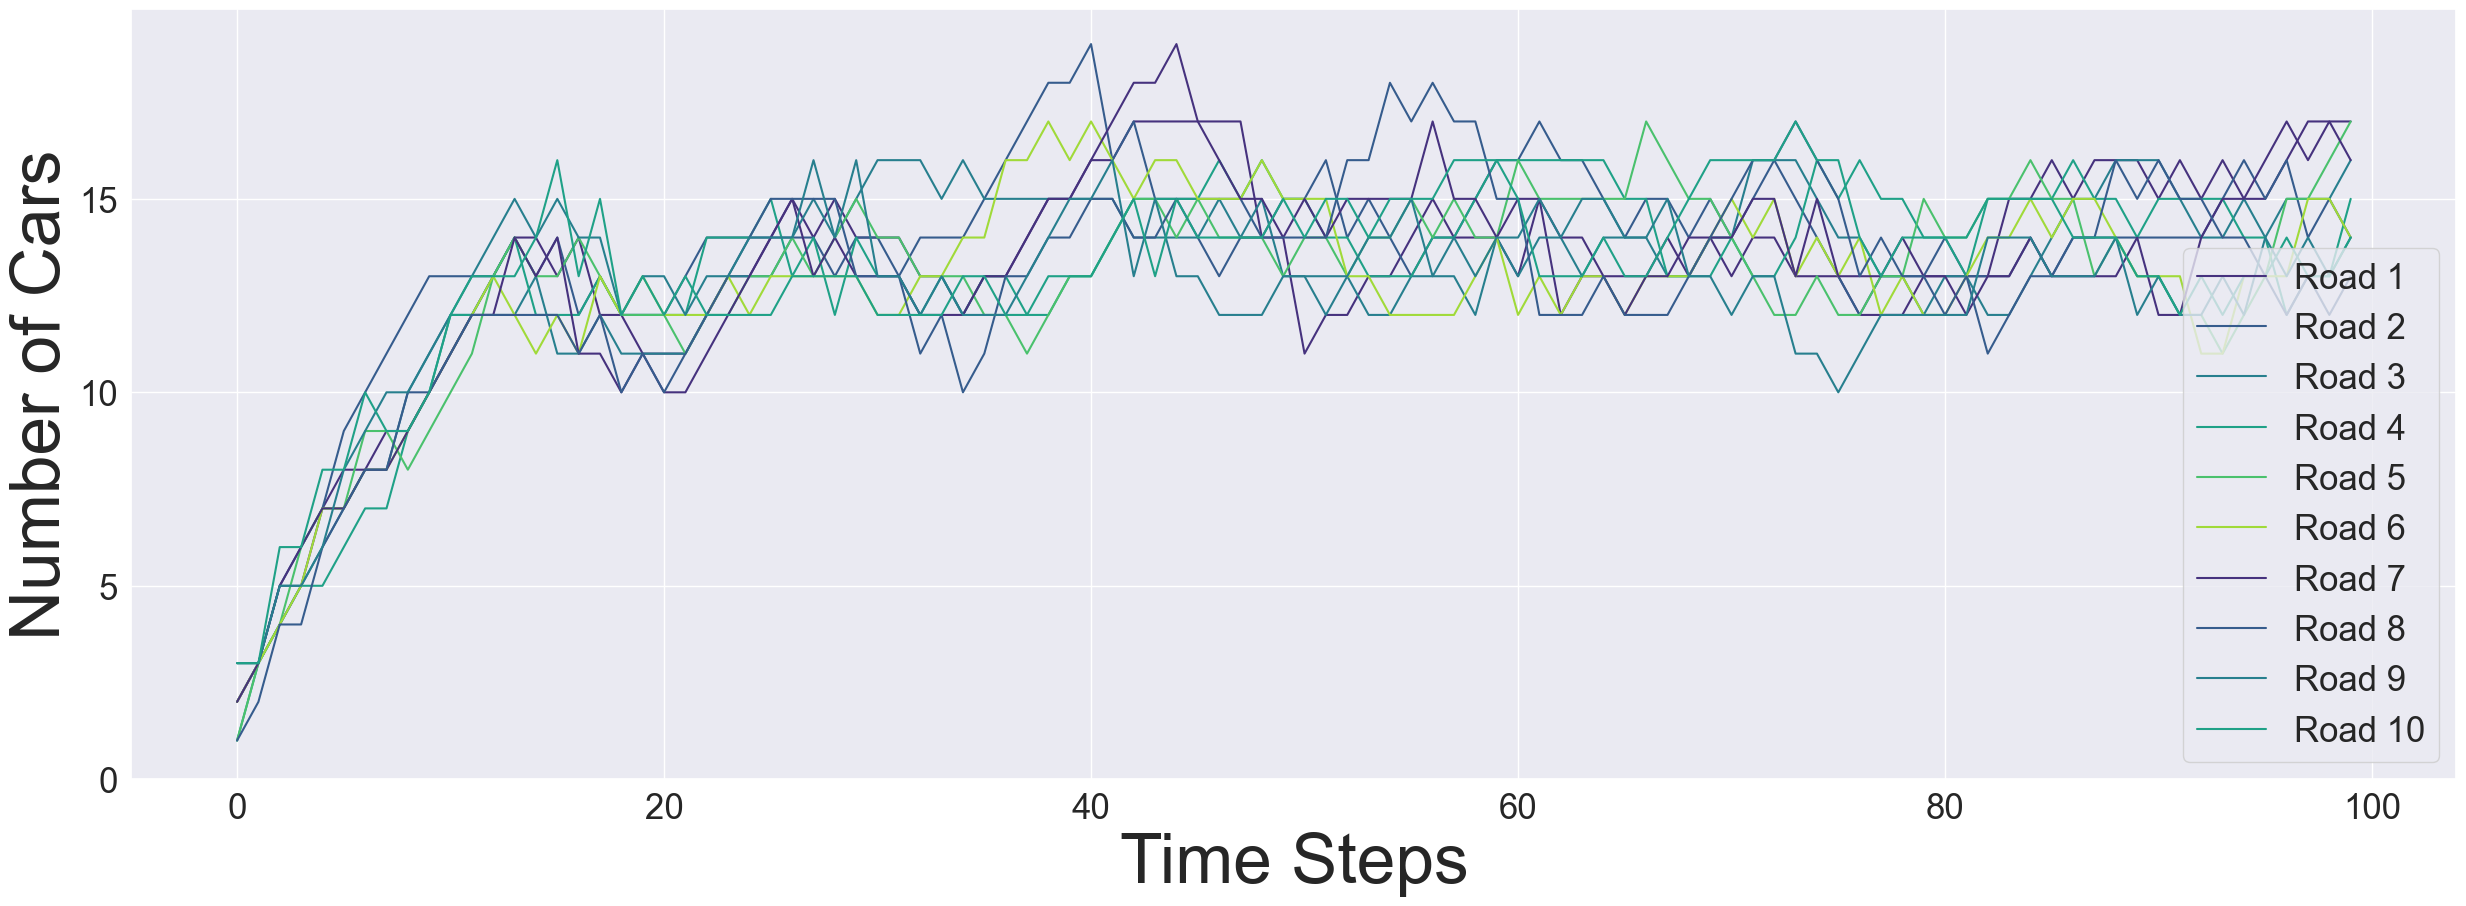

In [11]:
main(ROAD_CREATE_PARAMS, KEY)